In [1]:
###########################################
#Experimenting with Bayesian Models in Pyro
#------------------------------------------
# 1. Using a simple Bayes NN to fit a basic curve
# 2. Using a simple Bayes NN for a classification task
# 3. Adding a discrete hyper-parameter for number of output nodes in a Bayes NN

#Library Calls
import torch
import pyro
import matplotlib
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyro.distributions as dist

from torch import nn
from matplotlib.colors import ListedColormap
from pyro.distributions import Normal, Categorical
from pyro.infer import Predictive, config_enumerate
from pyro.nn.module import PyroModule, PyroParam, PyroSample, to_pyro_module_
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import HMC
from pyro.infer import EmpiricalMarginal
from pyro.infer.autoguide import AutoDelta
from pyro import poutine
from sklearn.preprocessing import OneHotEncoder

In [ ]:
#Sample Data for Curve Fitting

#Curve 1. Sin Wave
x = np.array([np.linspace(-20, 20, 1000)])
eps = np.random.randn(1000) #* 0.15*(x**2)
y = (20*np.sin(0.2*x)) + eps

#Curve 2. Basic Noisy Curve
#x = np.array([[-4, -3, -2, -1, 0, 1, 2, 3, 4, 5]])
#y = np.array([[1.0, 1.3, 1.4, 1.1, 0.6, -0.2, -0.8, -0.6, 0.3, 0.8]])

#Curve 3. Noisy Linear Function
#x = np.array([[-4, -3, -2, -1, 0, 1, 2, 3, 4, 5]])
#y = 3 * x + 2
#z = torch.normal(0,2,(10,1))
#x = 3 * x + 2 + z

#Plot Sample Data
#plt.scatter(x, y)
x = torch.t(torch.tensor(x).float())
y = torch.t(torch.tensor(y).float())

In [ ]:
#Deep Vanilla FNN (No Bayesian)
class BNN(torch.nn.Module):
    def __init__(self, n_hidden=32, n_out=1):
        super(BNN, self).__init__()
        self.fc1 = nn.Linear(1, n_hidden)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(n_hidden, n_out)
    def forward(self, x):
        output = self.fc1(x)
        output = self.tanh1(output)
        output = self.fc2(output)
        return output

bayes_net = BNN()
loss_function = torch.nn.MSELoss()
optim = torch.optim.Adam(bayes_net.parameters(), lr=0.05)

for i in range(1000):
    optim.zero_grad()
    predictions = bayes_net(x)
    loss = loss_function(predictions, y)
    loss.backward()
    if i%100 == 0:
        xx = torch.t(torch.tensor(np.array([np.linspace(-20, 20, 1000)])).float())
        yy = bayes_net.forward(xx).detach().numpy()
        plt.scatter(xx, yy)
        #plt.scatter(x, predictions.detach().numpy())
    optim.step()

xx = torch.t(torch.tensor(np.array([np.linspace(-20, 20, 1000)])).float())
yy = bayes_net.forward(xx).detach().numpy()

plt.scatter(xx, yy)
plt.scatter(x,y)
plt.scatter(x, predictions.detach().numpy(), c="red")

In [ ]:
#Bayesian NN 1: Curve Fitting
class BNN(nn.Module):
    def __init__(self, n_hidden=32, n_out=1):
        super(BNN, self).__init__()
        self.linear = nn.Linear(1, n_hidden)
        self.tanh1 = nn.ReLU()
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.tanh2 = nn.ReLU()
        self.linear3 = nn.Linear(n_hidden, n_out)
        self.sig = nn.Parameter(torch.rand(1))

    def forward(self, x, y=None):
        output = self.linear(x)
        output = self.tanh1(output)
        output = self.linear2(output)
        output = self.tanh2(output)
        output = self.linear3(output)

        with pyro.plate('data', x.shape[0]):
            #self.sig2 = pyro.sample('sig2',dist.HalfNormal(self.sig).expand([1]).to_event(1))
            obs = pyro.sample("obs",dist.Normal(output,self.sig),obs=y)
        return obs

net = BNN()
to_pyro_module_(net)
softplus = torch.nn.Softplus()

def guide(x,y):
    # First layer weight distribution priors
    l1_mu = torch.randn_like(net.linear.weight)
    l1_sig = torch.randn_like(net.linear.weight)
    l1_mu_p = pyro.param("l1_mu", l1_mu)
    l1_sig_p = softplus(pyro.param("l1_sig", l1_sig))
    l1w_prior = Normal(loc=l1_mu_p, scale=l1_sig_p)
    # First layer bias distribution priors
    l1b_mu = torch.randn_like(net.linear.bias)
    l1b_sig = torch.randn_like(net.linear.bias)
    l1b_mu_p = pyro.param("l1b_mu", l1b_mu)
    l1b_sig_p = softplus(pyro.param("l1b_sig", l1b_sig))
    l1b_prior = Normal(loc=l1b_mu_p, scale=l1b_sig_p)
    # Output layer weight distribution priors
    l2_mu = torch.randn_like(net.linear.weight)
    l2_sig = torch.randn_like(net.linear.weight)
    l2_mu_p = pyro.param("l2_mu", l2_mu)
    l2_sig_p = softplus(pyro.param("l2_sig", l2_sig))
    l2w_prior = Normal(loc=l2_mu_p, scale=l2_sig_p)
    # Output layer bias distribution priors
    l2b_mu = torch.randn_like(net.linear.bias)
    l2b_sig = torch.randn_like(net.linear.bias)
    l2b_mu_p = pyro.param("l2b_mu", l2b_mu)
    l2b_sig_p = softplus(pyro.param("l2b_sig", l2b_sig))
    l2b_prior = Normal(loc=l2b_mu_p, scale=l2b_sig_p)
    # Output layer weight distribution priors
    l3_mu = torch.randn_like(net.linear3.weight)
    l3_sig = torch.randn_like(net.linear3.weight)
    l3_mu_p = pyro.param("l3_mu", l2_mu)
    l3_sig_p = softplus(pyro.param("l3_sig", l3_sig))
    l3w_prior = Normal(loc=l3_mu_p, scale=l3_sig_p)
    # Output layer bias distribution priors
    l3b_mu = torch.randn_like(net.linear3.bias)
    l3b_sig = torch.randn_like(net.linear3.bias)
    l3b_mu_p = pyro.param("l3b_mu", l3b_mu)
    l3b_sig_p = softplus(pyro.param("l3b_sig", l3b_sig))
    l3b_prior = Normal(loc=l3b_mu_p, scale=l3b_sig_p)

    sig_prior = dist.HalfNormal(10)

    priors = {'linear.weight': l1w_prior, 'linear.bias': l1b_prior, 'linear2.weight': l2w_prior, 'linear2.bias': l2b_prior, 'linear3.weight': l3w_prior, 'linear3.bias': l3b_prior, 'sig': sig_prior}
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

adam = pyro.optim.Adam({"lr": 0.05})

svi = pyro.infer.SVI(net, guide, adam, loss=pyro.infer.Trace_ELBO())

In [ ]:
#MCMC Training Attempt
pyro.infer.mcmc.util.initialize_model(net, (x, y))
hmc_kernel = HMC(net, step_size=0.08, num_steps=4)
mcmc = MCMC(hmc_kernel, num_samples=1000, warmup_steps=100)
mcmc.run(x, y)
samples = mcmc.get_samples()
samples2 = mcmc.get_samples()

In [ ]:
model = pyro.infer.predictive.Predictive(net, samples, num_samples=2)
model2 = pyro.infer.predictive.Predictive(net, samples2, num_samples=1)
z = model(xx)['obs'][0,:,0].detach().numpy()
z2 = model2(xx)['obs'][0,:,0].detach().numpy()
plt.scatter(xx, z)
plt.scatter(xx, z2)
plt.scatter(x, y)

In [ ]:
model = pyro.infer.predictive.Predictive(net, samples, num_samples=2)
model2 = pyro.infer.predictive.Predictive(net, samples2, num_samples=1)
z = model(x)['obs'][0,:,0].detach().numpy()
z2 = model(x)['obs'][0,:,1].detach().numpy()
plt.scatter(x, z)
plt.scatter(x, z2)
plt.scatter(x, y)

In [ ]:
#Training Loop
pyro.clear_param_store()
num_iterations = 30000
losses = []
for j in range(num_iterations):
    #Calculate Loss, take a Gradient Step
    loss = svi.step(x, y)
    losses.append(loss/len(x))
    if j % 500 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x)))
        print(net.sig)

In [ ]:
num_samples = 1
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [bayes_net(x) for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return mean#, torch.stack(yhats)[:,:,0]

#z, zs = predict(x)
#print(zs)

#print(zs.size())

plt.scatter(x, y)

for i in range(5):
    xx = torch.t(torch.tensor(np.array([np.linspace(-50, 50, 1000)])).float())
    zz = predict(xx).detach().numpy()
    z = predict(x).detach().numpy()
    plt.scatter(xx, zz)

torch.Size([800])


800

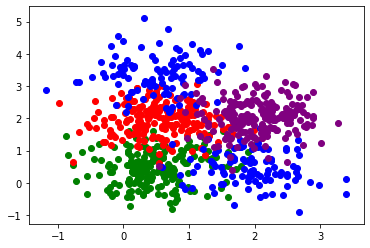

In [23]:
#########################
#Task 2 - Classification
#########################

#Set up Gaussian Data
num_samples = 200
mu1, mu2, mu3, mu4 = [[0.5,0.5], [0.5,2.0], [2.0,0.5], [2.0,2.0]]
sd = np.array([[0.18, 0.0], [0.0, 0.18]])
x1 = np.random.multivariate_normal(mu1, sd, (num_samples))
x2 = np.random.multivariate_normal(mu2, sd, (num_samples))
x3 = np.random.multivariate_normal(mu3, sd, (int(num_samples/2)))
x4 = np.random.multivariate_normal([0.5,3.5], sd, (int(num_samples/2)))
x5 = np.random.multivariate_normal(mu4, sd, (num_samples))
#x6 = np.random.multivariate_normal([3.0,2.5], sd, (10))
x3 = np.concatenate((x3,x4))

plt.scatter(x1[:,0],x1[:,1], c='green')
plt.scatter(x2[:,0],x2[:,1], c='red')
plt.scatter(x3[:,0],x3[:,1], c='blue')
plt.scatter(x5[:,0],x5[:,1], c='purple')

#Create Labels
y = np.array([int(np.floor(i/num_samples)) for i in range(num_samples*4)])
#y[100:300] = 2
#y[0:20] = 0
#y[20:40] = 1
#y[40:] = 2

x = np.concatenate((x1,x2,x3,x5))
newcmp = ListedColormap(['green','red','blue','purple'])
#plt.scatter(x[:,0],x[:,1],c=y,cmap=newcmp)

x = torch.tensor(x).float()
y = torch.tensor(y)
print(y.size())
len(x)

In [24]:
choices = []
p_mus = []
def count_it(branch):
    if branch == 0:
        choices.append(0)
    else:
        choices.append(1)
def p_it(branch):
    p_mus.append(branch)

    
#Commented text is for learning to switch between output layers
#The algorithm works, but is not technically reversible jumps
class BNN2(nn.Module):
    def __init__(self, input_size=2, hidden_size=32, output_size=4):
        super(BNN2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, 3)
        self.out2 = nn.Linear(hidden_size, 4)
        #self.p = nn.Parameter(torch.rand(1))
        self.p_mu = nn.Parameter(torch.rand(100))
        self.p_sd = nn.Parameter(torch.rand(1))
        
    def forward(self, x, y=None):
        output = self.fc1(x)
        output = nn.functional.relu(output)
        output1 = self.out(output)
        output2 = self.out2(output)
        new_column = torch.zeros_like(output1[:,0:1])
        #output1 = torch.cat((output1,new_column),dim=1)
        #output = output1

        #z = pyro.sample('z',dist.Normal(0,1))
        #p = self.p_mu + self.p_sd * z
        #p_it(p.item())

        #output = p*(output1) + (1-p)*(output2)
        
        #if p.item() <= 0.5:
            #count_it(0)
            #new_column = torch.zeros_like(output1[:,0:1])
            #output1 = torch.cat((output1,new_column),dim=1)
            #output = output1
        #elif p.item() > 0.5:
            #count_it(1)
            #output = output2
        
        #lhat = nn.functional.softmax(output1,dim=1)
        #lhat = torch.cat((lhat,new_column),dim=1)
        lhat = nn.functional.softmax(output2,dim=1)

        #score1 = (sum(sum(torch.abs(lhat - torch.tensor([0.25, 0.25, 0.5, 0])))))
        #score2 = (sum(sum(torch.abs(lhat2 - torch.tensor([0.25, 0.25, 0.5, 0])))))
        #pt = 1 - (score1 / (score1 + score2))
        #if pt > np.random.rand():
            #lhat = lhat
            #count_it(1)
        #else:
            #lhat = lhat2
            #count_it(0)

        return lhat

net = BNN2()
to_pyro_module_(net)

##########################################
#Variance parameter - try different values
##########################################
var = 8

def model(x, y):
    p_mu_prior = dist.Normal(0.5, 1.0)
    p_sd_prior = dist.HalfNormal(0.1)
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight)*var)
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias)*var)
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight)*var)
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias)*var)
    out2w_prior = Normal(loc=torch.zeros_like(net.out2.weight), scale=torch.ones_like(net.out2.weight)*var)
    out2b_prior = Normal(loc=torch.zeros_like(net.out2.bias), scale=torch.ones_like(net.out2.bias)*var)
    #in_k = pyro.sample('k',Categorical(probs=torch.tensor([net.p,1-net.p])))
    priors = {'p_mu': p_mu_prior, 'p_sd': p_sd_prior, 'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior, 'out2.weight': out2w_prior, 'out2.bias': out2b_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    #p = pyro.sample("p", dist.Beta(2,2))

    lhat = lifted_reg_model(x)
    #Decide which network vector to use
    #score1 = (sum(sum(torch.abs(t1 - torch.tensor([0.25, 0.25, 0.5, 0])))))
    #score2 = (sum(sum(torch.abs(t2 - torch.tensor([0.25, 0.25, 0.5, 0])))))
    #pt = 1 - (score1 / (score1 + score2))
    #prop = np.random.rand()
    
    #if pt >= prop:
        #count_it(1)
        #lhat = t1
    #else:
        #count_it(0)
        #lhat = t2
    
    with pyro.plate('data', x.shape[0]):
            obs = pyro.sample("obs", Categorical(probs=lhat), obs=y)

softplus = torch.nn.Softplus()


#The guide function acts as Q(x) for SVI
def guide(x, y):

    #p variable for model selection
    a = torch.tensor([1.0]).float()
    b = torch.tensor([0.1]).float()
    alpha = pyro.param("alpha", a)
    beta = pyro.param("beta", b)
    #model_indicator_prior = dist.Beta(alpha, beta)
    p_mu_prior = dist.Normal(0.5, alpha)
    p_sd_prior = dist.HalfNormal(beta)

    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)*var
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)*var
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)*var
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)*var
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    # Output layer 2 weight distribution priors
    out2w_mu = torch.randn_like(net.out2.weight)
    out2w_sigma = torch.randn_like(net.out2.weight)*var
    out2w_mu_param = pyro.param("out2w_mu", out2w_mu)
    out2w_sigma_param = softplus(pyro.param("out2w_sigma", out2w_sigma))
    out2w_prior = Normal(loc=out2w_mu_param, scale=out2w_sigma_param).independent(1)
    # Output layer 2 bias distribution priors
    out2b_mu = torch.randn_like(net.out2.bias)
    out2b_sigma = torch.randn_like(net.out2.bias)*var
    out2b_mu_param = pyro.param("out2b_mu", out2b_mu)
    out2b_sigma_param = softplus(pyro.param("out2b_sigma", out2b_sigma))
    out2b_prior = Normal(loc=out2b_mu_param, scale=out2b_sigma_param)

    priors = {'p_mu': p_mu_prior, 'p_sd': p_sd_prior, 'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior, 'out2.weight': out2w_prior, 'out2.bias': out2b_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

optim = pyro.optim.Adam({"lr": 0.005})
svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO())

In [27]:
#Sampling function
num_samples = 1
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [f(x).data for f in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1), mean

#Massive Plotting function for visualizing network output
greenMap = plt.cm.Greens
redMap = plt.cm.Reds
blueMap = plt.cm.Blues
purpleMap = plt.cm.Purples

grmap = greenMap(np.arange(greenMap.N))
rdmap = redMap(np.arange(redMap.N))
blmap = blueMap(np.arange(blueMap.N))
prmap = purpleMap(np.arange(purpleMap.N))

grmap[:,-1] = np.linspace(0, 1, greenMap.N)**10
rdmap[:,-1] = np.linspace(0, 1, redMap.N)**10
blmap[:,-1] = np.linspace(0, 1, blueMap.N)**10
prmap[:,-1] = np.linspace(0, 1, purpleMap.N)**10

grmap[:100,-1] = 0
rdmap[:100,-1] = 0
blmap[:100,-1] = 0
prmap[:100,-1] = 0

grmap = ListedColormap(grmap)
rdmap = ListedColormap(rdmap)
blmap = ListedColormap(blmap)
prmap = ListedColormap(prmap)

newcmp2 = ListedColormap(['green','red','blue','purple'])

def plot_it():    
    #z, z_vals = predict(x)

    xx = torch.tensor(np.linspace(-1.5, 4, 100))
    yy = torch.tensor(np.linspace(-1.5, 5, 100))
    gridx, gridy = torch.meshgrid(xx, yy)
    gridx = torch.flatten(gridx)
    gridy = torch.flatten(gridy)
    gridz = torch.t(torch.stack((gridx,gridy)).float())

    z2, z2_vals = predict(gridz)

    #sdevs = torch.std(z2_vals, axis=1)
    green = z2_vals[:,0]
    red = z2_vals[:,1]
    blue = z2_vals[:,2]
    purple = z2_vals[:,3]

    green_grid = z2_vals[:,0].reshape(100,100)
    red_grid = z2_vals[:,1].reshape(100,100)
    blue_grid = z2_vals[:,2].reshape(100,100)
    purple_grid = z2_vals[:,3].reshape(100,100)

    fig, ax = plt.subplots()

    ax.scatter(gridz[:,0],gridz[:,1],c=green, cmap=grmap)
    ax.scatter(gridz[:,0],gridz[:,1],c=red, cmap=rdmap)
    ax.scatter(gridz[:,0],gridz[:,1],c=blue, cmap=blmap)
    ax.scatter(gridz[:,0],gridz[:,1],c=purple, cmap=prmap)
    #ax.scatter(gridz[:,0],gridz[:,1],c=sdevs, cmap='Greys')
    ax.scatter(x[:,0],x[:,1],c=y,cmap=newcmp2)

    #fig = plt.figure(frameon=False)

    #z1 = plt.imshow(green_grid, cmap=grmap, origin='lower', interpolation = 'bilinear')
    #z2 = plt.imshow(red_grid, cmap=rdmap, origin='lower', interpolation = 'bilinear', alpha=0.8)
    #z3 = plt.imshow(blue_grid, cmap=blmap, origin='lower', interpolation = 'bilinear', alpha=0.7)
    #z4 = plt.imshow(purple_grid, cmap=prmap, origin='lower', interpolation = 'bilinear', alpha=0.5)

    #Save a GIF
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

In [25]:
#Training Loop
pyro.clear_param_store()
num_iterations = 20001
ims = []
for j in range(num_iterations):
    #Calculate Loss, take a Gradient Step
    loss = svi.step(x, y) + 0.5
    if j % 500 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x)))
        #print(np.mean(choices))
 
    #Uncomment the four following lines to create a GIF of network training

        #im = plot_it()
        #ims.append(im)
#kwargs_write = {'fps':15.0, 'quantizer':'nq'}
#imageio.mimsave('./training_narrow.gif', ims, fps=10)


[iteration 0001] loss: 10.9565
[iteration 0101] loss: 13.5334
[iteration 0201] loss: 12.1388
[iteration 0301] loss: 11.5552
[iteration 0401] loss: 13.1210
[iteration 0501] loss: 12.5595
[iteration 0601] loss: 13.4730
[iteration 0701] loss: 10.5524
[iteration 0801] loss: 13.0374
[iteration 0901] loss: 11.2847
[iteration 1001] loss: 13.6626
[iteration 1101] loss: 10.6217
[iteration 1201] loss: 10.9289
[iteration 1301] loss: 12.2429
[iteration 1401] loss: 12.7427
[iteration 1501] loss: 12.7664
[iteration 1601] loss: 10.8065
[iteration 1701] loss: 12.7153
[iteration 1801] loss: 9.5148
[iteration 1901] loss: 12.7288
[iteration 2001] loss: 12.6373
[iteration 2101] loss: 12.4958
[iteration 2201] loss: 12.5861
[iteration 2301] loss: 11.2263
[iteration 2401] loss: 11.6901
[iteration 2501] loss: 8.6856
[iteration 2601] loss: 8.1584
[iteration 2701] loss: 10.6774
[iteration 2801] loss: 12.2094
[iteration 2901] loss: 5.8659
[iteration 3001] loss: 10.9971
[iteration 3101] loss: 8.7710
[iteration 32

RuntimeError: Zero images were written.

In [26]:
num_samples = 1
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [f(x).data for f in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1), mean

z, z_vals = predict(x)

xx = torch.tensor(np.linspace(-1.5, 5, 100))
gridx, gridy = torch.meshgrid(xx, xx)
gridx = torch.flatten(gridx)
gridy = torch.flatten(gridy)
gridz = torch.t(torch.stack((gridx,gridy)).float())

z2, z2_vals = predict(gridz)
from matplotlib.colors import ListedColormap
newcmp = ListedColormap(['green','red','blue','purple'])
#plt.scatter(gridz[:,0],gridz[:,1],alpha=0.05,c=z2,cmap=newcmp)
#plt.scatter(x[:,0],x[:,1],c=y,cmap=newcmp)

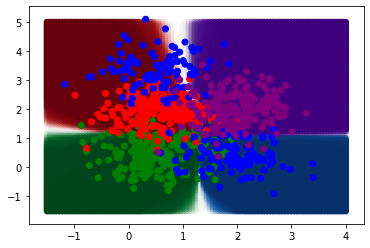

In [28]:
test = plot_it()